In [87]:
from pprint import pprint
import numpy as np
import re
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
profiles = pd.read_csv('C:/Users/maksim/QuickDatingModel/Data/okcupid_profiles.csv')

In [3]:
profiles.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [4]:
profiles.shape

(59946, 31)

<Axes: xlabel='count', ylabel='sex'>

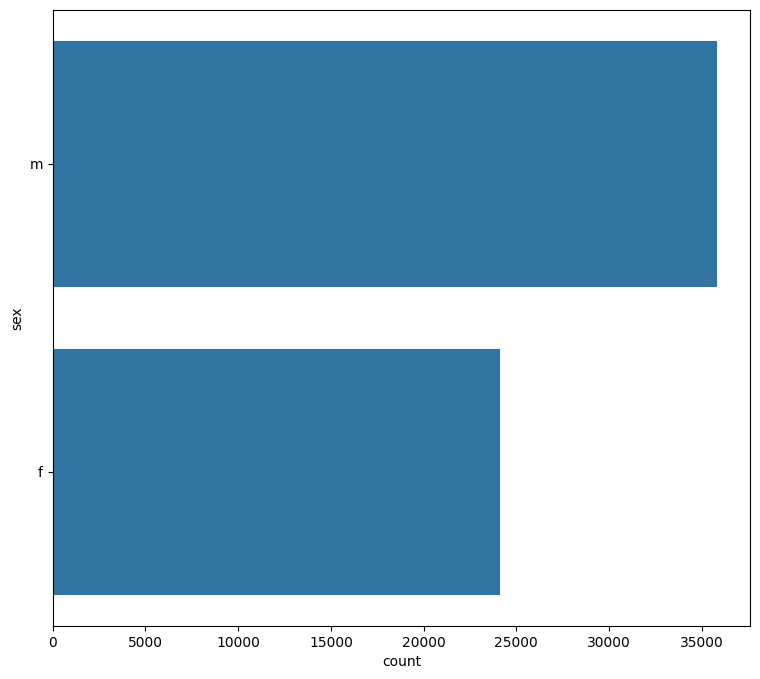

In [40]:
plt.figure(figsize=(9, 8))
sns.countplot(profiles['sex'])

In [5]:
df = profiles.copy()
df['height'] = df['height'].apply(lambda x: round(x * 2.54, 0))

In [6]:
df = df.drop(['orientation', 'diet', 'ethnicity', 'last_online', 'pets', 'religion', 'drugs'], axis=1)

In [7]:
df.shape

(59946, 24)

In [8]:
df.isna().sum()

age              0
status           0
sex              0
body_type     5296
drinks        2985
education     6628
height           3
income           0
job           8198
location         0
offspring    35561
sign         11056
smokes        5512
speaks          50
essay0        5488
essay1        7572
essay2        9638
essay3       11476
essay4       10537
essay5       10850
essay6       13771
essay7       12451
essay8       19225
essay9       12603
dtype: int64

In [9]:
mask = df['height'].mean()
df.loc[mask, 'height'] = df['height'].median()
df.loc[df.income == -1, 'income'] = np.NaN
isna_cols = df.loc[:, df.isna().any()].columns
missing_values = df[isna_cols[:12]].isna().sum().sort_values(ascending=False)

df['age'] = df['age'].fillna(df['age'].mean())
df['height'] = df['height'].fillna(df['height'].mean())

In [10]:
def map_cat(a_string, a_dic):
    """
    a_string: a string we want to map with a_dic
    a_dic: a dictionary whose keys are tuples
    """
    for k in a_dic:
        if a_string in k:
            return a_dic.get(k)
    return np.NaN

In [11]:
body_types_dic = {('skinny', 'used up', 'thin'): 'ectomorph',
                 ('average', 'fit', 'athletic', 'jacked'): 'mesomorph',
                 ('a little extra', 'curvy', 'full figured'): 'endomorph'}

body_categories = CategoricalDtype(categories=['ectomorph', 'mesomorph',
                                              'endomorph'], ordered=True)

df['body_type_'] = df.body_type.apply(map_cat, args=(body_types_dic,)).astype(body_categories)
df.body_type_ = df.body_type_.fillna(body_categories.categories
                        [int(np.median(df.body_type_.cat.codes))])

education_categories = CategoricalDtype(categories=['High school or less',
                                                   'Some college',
                                                   'College or more',
                                                   'Post graduate degree'],
                                       ordered=True)

education_dic= {('graduated from high school','dropped out of high school', 
                 'working on high school','high school'): 'High school or less',
                
                ('working on two-year college','dropped out of space camp',
                'two-year college', 'graduated from two-year college',
                'dropped out of college/university','dropped out of two-year college', 
                 'dropped out of med school', 'dropped out of law school'): 'Some college',
                
                ('working on college/university', 'working on space camp',
                'graduated from masters program','graduated from college/university',
                'working on masters program','graduated from space camp',
                'college/university','graduated from law school', 
                 'working on ph.d program','space camp', 
                 'graduated from med school','working on med school',
                'masters program', 'dropped out of ph.d program',
                'law school','dropped out of masters program',
                'working on law school', 'med school') : 'College or more', 
                
                ('graduated from ph.d program','ph.d program'): 'Post graduate degree'}

df['education_'] = df.education.apply(map_cat, args=(education_dic,)).astype(education_categories)

In [12]:
df.education_ = df.education_.fillna(education_categories.\
                                    categories[int(np.median(df['education_'].cat.codes))]).astype(education_categories)

In [13]:
drinks_categories = CategoricalDtype(categories=['not at all', 'rarely',
                                                'socially',
                                                'often', 'very often',
                                                'desperately'],
                                    ordered=True)
df['drinks_'] = df.drinks.astype(drinks_categories)
df.drinks_ = df.drinks_.fillna(drinks_categories.categories[int(np.median(df.drinks_.cat.codes))])

In [14]:
smokes_dic = {('no',): 'no',
             ('sometimes', 'when drinking', 'trying to quit'): 'sometimes',
             ('yes',):'yes'}
smokes_categories = CategoricalDtype(categories=['no', 'sometimes',
                                                'yes'], ordered=True)
df['smokes_'] = df.smokes.apply(map_cat, args=(smokes_dic,)).astype(smokes_categories)
df.smokes_ = df.smokes_.fillna('no').astype(smokes_categories)
df.smokes_.value_counts(dropna=False).sort_index()

smokes_
no           49409
sometimes     8307
yes           2231
Name: count, dtype: int64

In [30]:
sex_categories = CategoricalDtype(categories=['m','f'], ordered=True)
df.sex = df.sex.astype(sex_categories)

In [36]:
df.sex.unique()

['m', 'f', NaN]
Categories (2, object): ['m' < 'f']

In [42]:
df.sex = df.sex.fillna('m')

In [43]:
df.isna().sum()

age               0
status            1
sex               0
body_type      5297
drinks         2986
education      6629
height            0
income        48443
job            8199
location          1
offspring     35562
sign          11057
smokes         5513
speaks           51
essay0         5489
essay1         7573
essay2         9639
essay3        11477
essay4        10538
essay5        10851
essay6        13772
essay7        12452
essay8        19226
essay9        12604
body_type_        0
education_        0
drinks_           0
smokes_           0
dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59947 entries, 0.0 to 173.4599703051232
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         59947 non-null  float64 
 1   status      59946 non-null  object  
 2   sex         59947 non-null  category
 3   body_type   54650 non-null  object  
 4   drinks      56961 non-null  object  
 5   education   53318 non-null  object  
 6   height      59947 non-null  float64 
 7   income      11504 non-null  float64 
 8   job         51748 non-null  object  
 9   location    59946 non-null  object  
 10  offspring   24385 non-null  object  
 11  sign        48890 non-null  object  
 12  smokes      54434 non-null  object  
 13  speaks      59896 non-null  object  
 14  essay0      54458 non-null  object  
 15  essay1      52374 non-null  object  
 16  essay2      50308 non-null  object  
 17  essay3      48470 non-null  object  
 18  essay4      49409 non-null  object  


In [15]:
df.head()

,age,status,sex,body_type,drinks,education,height,income,job,location,offspring,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,body_type_,education_,drinks_,smokes_
0.0,22.0,single,m,a little extra,socially,working on college/university,190.0,NaN,transportation,"south san francisco, california","doesn't have kids, but might want them",gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,endomorph,College or more,socially,sometimes
1.0,35.0,single,m,average,often,working on space camp,178.0,80000.0,hospitality / travel,"oakland, california","doesn't have kids, but might want them",cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,mesomorph,College or more,often,no
2.0,38.0,available,m,thin,socially,graduated from masters program,173.0,NaN,NaN,"san francisco, california",NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",ectomorph,College or more,socially,no
3.0,23.0,single,m,thin,socially,working on college/university,180.0,20000.0,student,"berkeley, california",doesn't want kids,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,ectomorph,College or more,socially,no
4.0,29.0,single,m,athletic,socially,graduated from college/university,168.0,NaN,artistic / musical / writer,"san francisco, california",NaN,aquarius,no,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN,mesomorph,College or more,socially,no


In [45]:
features = ['age', 'height', 'body_type_', 'education_', 'drinks_', 'smokes_', 'sex']

In [46]:
df_c = df[features[0:2]].copy()
for feat in features[2:]:
    df_c[feat] = df[feat].cat.codes
    
    
df_c.isnull().sum()

age           0
height        0
body_type_    0
education_    0
drinks_       0
smokes_       0
sex           0
dtype: int64

In [47]:
df_c.head()

,age,height,body_type_,education_,drinks_,smokes_,sex
0.0,22.0,190.0,2,2,2,1,0
1.0,35.0,178.0,1,2,3,0,0
2.0,38.0,173.0,0,2,2,0,0
3.0,23.0,180.0,0,2,2,0,0
4.0,29.0,168.0,1,2,2,0,0


In [50]:
df_c.nunique()

age           55
height        61
body_type_     3
education_     4
drinks_        6
smokes_        3
sex            2
dtype: int64

In [49]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59947 entries, 0.0 to 173.4599703051232
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         59947 non-null  float64
 1   height      59947 non-null  float64
 2   body_type_  59947 non-null  int8   
 3   education_  59947 non-null  int8   
 4   drinks_     59947 non-null  int8   
 5   smokes_     59947 non-null  int8   
 6   sex         59947 non-null  int8   
dtypes: float64(2), int8(5)
memory usage: 3.7 MB


Предсказание метчей

In [103]:
from itertools import combinations
from itertools import islice
import random

profiles_match = pd.DataFrame(df_c)

sample_size = 1000
sample_users = random.sample(list(profiles_match.index), sample_size)

male_users = [user for user in sample_users if profiles_match.loc[user, 'sex'] == 0]
female_users = [user for user in sample_users if profiles_match.loc[user, 'sex'] == 1]

pairs = list(combinations(male_users, 1)) + list(combinations(female_users, 1))
pairs_df = pd.DataFrame(
    [(m, w) for m in male_users for w in female_users],
    columns=['user1', 'user2']
)
def match_probability(user1, user2, profiles_match):
    age_diff = abs(profiles_match.loc[user1, 'age'] - profiles_match.loc[user2, 'age'])
    same_body_type = profiles_match.loc[user1, 'body_type_'] == profiles_match.loc[user2, 'body_type_']
    same_drinks = profiles_match.loc[user1, 'drinks_'] == profiles_match.loc[user2, 'drinks_']
    same_smokes = profiles_match.loc[user1, 'smokes_'] == profiles_match.loc[user2, 'smokes_']

    probability = 0.65 - (age_diff / 30) ** 2
    if same_body_type:
        probability += 0.1
    if same_drinks:
        probability += 0.1
    if same_smokes:
        probability += 0.1
    
    return max(min(probability, 1.0), 0.0)

pairs_df['match_probability'] = pairs_df.apply(
    lambda row: match_probability(row['user1'], row['user2'], profiles_match), axis=1
)

user1    0
user2    0
dtype: int64


In [102]:
pairs_df.isna().sum()

user1                0
user2                0
match_probability    0
dtype: int64

In [56]:
pairs_df.shape

(244375, 3)

In [57]:
pairs_df.sort_values(by=['match_probability']).head(10)

,user1,user2,match_probability
69525,20455.0,450.0,0.0
63614,32009.0,25066.0,0.0
97621,54097.0,47076.0,0.0
97618,54097.0,17182.0,0.0
63615,32009.0,49210.0,0.0
63617,32009.0,17054.0,0.0
63618,32009.0,17182.0,0.0
236809,43349.0,59356.0,0.0
63621,32009.0,47076.0,0.0
63622,32009.0,47341.0,0.0


In [58]:
pairs_df.describe()

,user1,user2,match_probability
count,244375.000000,244375.000000,244375.000000
mean,28361.747826,31317.400000,0.658015
std,16335.918384,18474.208533,0.257967
min,12.000000,190.000000,0.000000
25%,14972.000000,15030.000000,0.590000
50%,27161.000000,30928.000000,0.738889
75%,40996.000000,48640.000000,0.840000
max,59939.000000,59807.000000,0.950000


C:\Users\maksim\AppData\Local\Temp\ipykernel_1020\2240126644.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pairs_df['match_probability'], color='g');


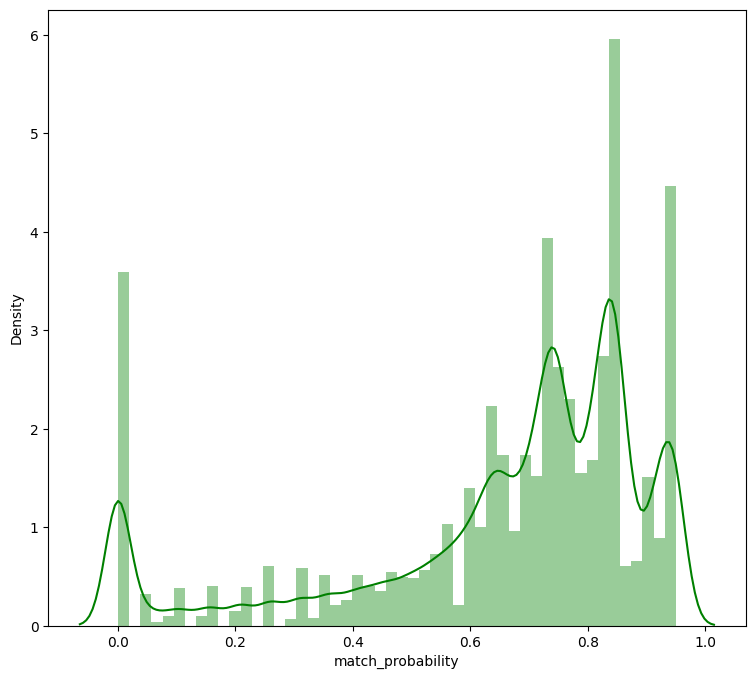

In [59]:
plt.figure(figsize=(9, 8))
sns.distplot(pairs_df['match_probability'], color='g');

In [60]:
pairs_df['match'] = pairs_df['match_probability'] > 0.7

In [61]:
pairs_df.head()

,user1,user2,match_probability,match
0,55676.0,16029.0,0.348889,False
1,55676.0,59533.0,0.055556,False
2,55676.0,49474.0,0.740000,True
3,55676.0,57955.0,0.578889,False
4,55676.0,16774.0,0.710000,True


In [62]:
pairs_df['match'] = pairs_df['match']*1

In [64]:
pairs_df.head()

,user1,user2,match_probability,match
0,55676.0,16029.0,0.348889,0
1,55676.0,59533.0,0.055556,0
2,55676.0,49474.0,0.740000,1
3,55676.0,57955.0,0.578889,0
4,55676.0,16774.0,0.710000,1


In [65]:
pairs_df.describe()

,user1,user2,match_probability,match
count,244375.000000,244375.000000,244375.000000,244375.000000
mean,28361.747826,31317.400000,0.658015,0.578549
std,16335.918384,18474.208533,0.257967,0.493792
min,12.000000,190.000000,0.000000,0.000000
25%,14972.000000,15030.000000,0.590000,0.000000
50%,27161.000000,30928.000000,0.738889,1.000000
75%,40996.000000,48640.000000,0.840000,1.000000
max,59939.000000,59807.000000,0.950000,1.000000


In [66]:
pairs_df.shape

(244375, 4)

In [68]:
df_c.head()

,age,height,body_type_,education_,drinks_,smokes_,sex
0.0,22.0,190.0,2,2,2,1,0
1.0,35.0,178.0,1,2,3,0,0
2.0,38.0,173.0,0,2,2,0,0
3.0,23.0,180.0,0,2,2,0,0
4.0,29.0,168.0,1,2,2,0,0


In [69]:
df_c.shape

(59947, 7)

In [90]:
pairs_with_profiles = pairs_df.copy()
pairs_with_profiles = pairs_with_profiles.merge(df_c.add_suffix('_user1'), left_on='user1', right_index=True)
pairs_with_profiles = pairs_with_profiles.merge(df_c.add_suffix('_user2'), left_on='user2', right_index=True)

pairs_with_profiles['age_diff'] = abs(pairs_with_profiles['age_user1'] - pairs_with_profiles['age_user2'])
pairs_with_profiles['education_diff'] = abs(pairs_with_profiles['education__user1'] - pairs_with_profiles['education__user2'])
pairs_with_profiles['drinks_same'] = (pairs_with_profiles['drinks__user1'] == pairs_with_profiles['drinks__user2']).astype(int)
pairs_with_profiles['smokes_same'] = (pairs_with_profiles['smokes__user1'] == pairs_with_profiles['smokes__user2']).astype(int)
pairs_with_profiles['body_type_same'] = (pairs_with_profiles['body_type__user1'] == pairs_with_profiles['body_type__user2']).astype(int)
pairs_with_profiles = pairs_with_profiles[['age_diff', 'education_diff', 'drinks_same', 'smokes_same', 'body_type_same', 'match', 'match_probability'\
                                          , 'user1', 'user2', 'sex_user1', 'sex_user2' ]]

In [96]:
pairs_with_profiles.head()

,age_diff,education_diff,drinks_same,smokes_same,body_type_same,match,match_probability,user1,user2,sex_user1,sex_user2
0,19.0,0,0,0,1,0,0.348889,55676.0,16029.0,0,1
1,25.0,0,0,0,1,0,0.055556,55676.0,59533.0,0,1
2,3.0,0,0,0,1,1,0.740000,55676.0,49474.0,0,1
3,8.0,0,0,0,0,0,0.578889,55676.0,57955.0,0,1
4,6.0,0,0,0,1,1,0.710000,55676.0,16774.0,0,1


In [97]:
pairs_with_profiles.shape

(244375, 11)

In [98]:
unique_users = pd.unique(pairs_df[['user1', 'user2']].values.ravel('K'))

filtered_profiles = df_c[df_c.index.isin(unique_users)]

filtered_profiles.shape

(1000, 7)

Импортируем

In [99]:
pwp = pairs_with_profiles.to_csv('pairs_with_profiles.csv', index = True)
fp = filtered_profiles.to_csv('filtered_profiles.csv', index = True)
ap = df_c.to_csv('all_profiles.csv', index = True)
p = pairs_df.to_csv('only_pairs.csv', index = True)